In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import torch
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

%matplotlib inline

/home/ryanliu/.conda/envs/285/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_logs(path):
    acc = EventAccumulator(path)
    df = None
    acc.Reload()
    for tag in acc.Tags()['scalars']:
        if df is None:
            df = pd.DataFrame(acc.Scalars(tag)).rename(columns={"value": tag})[["step", tag]]
        else:
            new_df = pd.DataFrame(acc.Scalars(tag)).rename(columns={"value": tag})
            df = pd.merge(df, new_df[["step", tag]], on="step", how="outer")
    return df

def accumulate_logs(paths):
    dfs = []
    for path in paths:
        try:
            dfs.append(load_logs(path))
        except:
            pass
    df = pd.concat(dfs, ignore_index=True)
    df = df.groupby(pd.cut(df["step"], bins = 10), observed=True).agg(["mean", "std"])
    return df

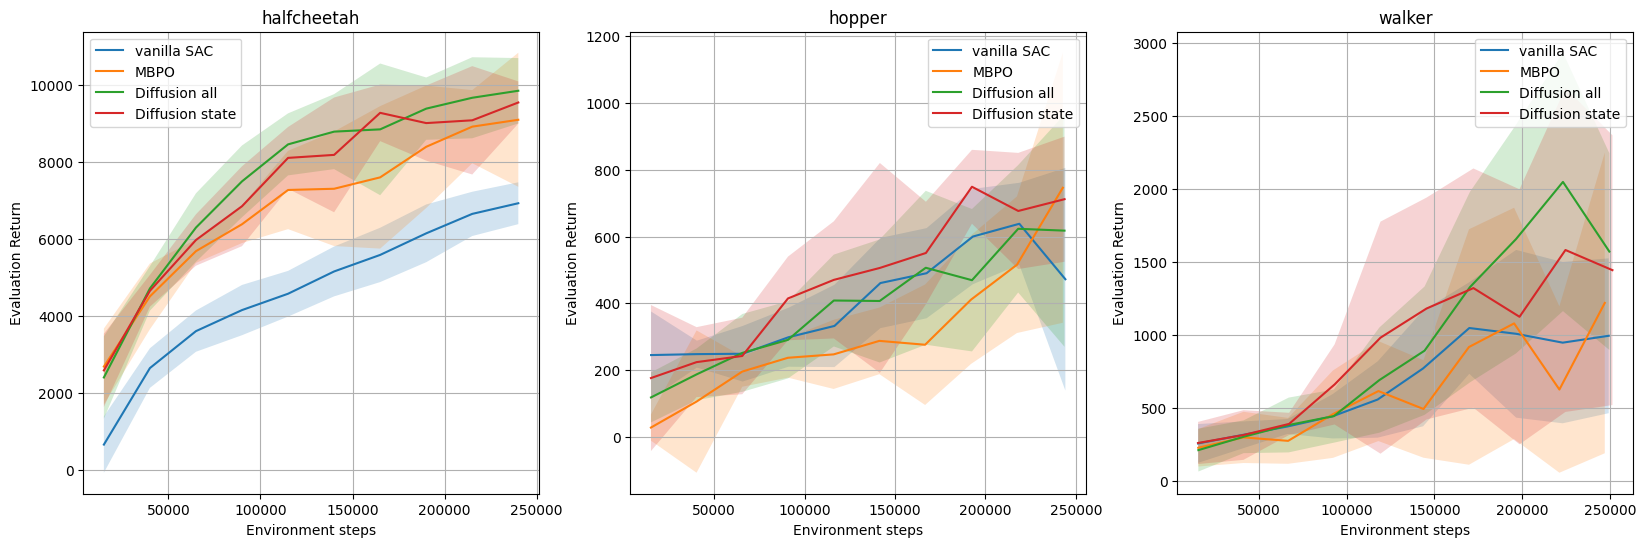

In [5]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize=(20, 6))
for name, ax in zip(["halfcheetah_data", "hopper_data", "walker_data"], axs.flatten()):
    paths = {"vanilla SAC": [], "MBPO": [], "Diffusion all": [], "Diffusion state": []}
    for dp, dn, fn in os.walk(os.path.expanduser(name)):
        for f in fn:
            if dp.split("_")[7] == "mbpo0":
                paths["vanilla SAC"].append(os.path.join(dp, f))
            elif dp.split("_")[7] == "mbpo5":
                paths["MBPO"].append(os.path.join(dp, f))
            elif dp.split("_")[8] == "all":
                paths["Diffusion all"].append(os.path.join(dp, f))
            elif dp.split("_")[8] == "state":
                paths["Diffusion state"].append(os.path.join(dp, f))
    for label, path in paths.items():
        try:
            df = accumulate_logs(path)
            ax.plot(df["total_envsteps"]["mean"], df["eval_return"]["mean"], label = label)
            ax.fill_between(df["total_envsteps"]["mean"], df["eval_return"]["mean"] - df["eval_return"]["std"], df["eval_return"]["mean"] + df["eval_return"]["std"], alpha = 0.2)
        except:
            pass
    ax.legend()
    ax.set_title(name.split("_")[0])
    ax.grid(which="major")
    ax.set_xlabel("Environment steps")
    ax.set_ylabel("Evaluation Return")
plt.show()